In [4]:
import numpy as np
import matplotlib.pyplot as plt
import MITgcmutils as mit
import cmocean 
import xarray as xr
from scipy.spatial import cKDTree
from numba import njit
from matplotlib.colors import Normalize # Normalizeをimport
from matplotlib.colors import TwoSlopeNorm
from geopy.distance import great_circle
import cartopy.crs as ccrs
import os
import netCDF4
from matplotlib.tri import Triangulation
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter


In [65]:
#fileloc of bathymetry to use
fileloc_bathy = '/home/tsuribeh/Forcing_data/bathymetries/Baatsen_2016/'
# fileloc_bathy = '/home/tsuribeh/bathymetries/etopo1/'
# fileloc_bathy = '/home/tsuribeh/Forcing_data//bathymetries/Straume_2020/'



#fileloc of forcing &inialstate data
fileloc_go_input = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/ETOPO1_global_ocean.cs32x15/input/'

#fileloc of input folder to use 
fileloc_to_write =''

# if not os.path.isdir(fileloc_to_write):
#     os.makedirs(fileloc_to_write)

#自分で好きに設定
filename_bathy = ''
filename_hydrogTheta = 'hydrogTheta_St50Ma_cs32x15.bin'
filename_hydrogSalt = 'hydrogSalt_St50Ma_cs32x15.bin' #might work without adapting to each bathies, but adapted in default setting
filename_TauX ='trenberth_TauX_polar_averaged_sym.bin' #not depend on bathy
filename_TauY ='trenberth_TauY_averaged_antisym.bin' #not depend on bathy
filename_SST ='lev_SST_EarlyEoceneSeason_St50Ma_cs32x2seasons.bin'
# filename_SST ='lev_SST_sym_Pm38Ma_cs32x12m.bin'
filename_SSS ='lev_SSS_polar_sym_tuned_St50Ma_cs32x2seasons.bin'

In [69]:
#import bathymetry(lonlat grid)

bathy_ds = xr.load_dataset(fileloc_bathy+'baatsen_38Ma_HotSpot.nc')
# bathy_ds = xr.load_dataset(fileloc_bathy+'paleobathy-topo_35.00Ma_Straume_et_al.nc')
# bathy_ds = netCDF4.Dataset(fileloc_bathy+'ETOPO1_Ice_g_gmt4.grd', 'r')

bathy_ds

<xarray.Dataset> Size: 2MB
Dimensions:    (latitude: 360, longitude: 720)
Coordinates:
  * latitude   (latitude) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    Z          (latitude, longitude) float64 2MB 1.072e+03 ... -4.009e+03

In [71]:
#make grid data of bathy(lonlat)

# c =5 #Straume every 0.5 deg.
# c =30 #ETOPO1 every 0.5 deg.

c=1 #Baatsen
# lon_ = np.array(bathy_ds['lon'][::c])#Straume
# lat_ = np.array(bathy_ds['lat'][::c])#Straume
# lon_ = np.array(bathy_ds.variables['x'][::c]) #ETOPO1
# lat_ = np.array(bathy_ds.variables['y'][::c]) #ETOPO1
lon_ = np.array(bathy_ds['longitude'][::c])#Baatsen
lat_ = np.array(bathy_ds['latitude'][::c])#Baatsen

lon,lat = np.meshgrid(lon_,lat_)
lonlat = np.stack([lon,lat],axis=2)

#loag raw bathy data
# bathy_raw = np.array(bathy_ds['z'][::c,::c]).astype('float')
bathy_raw = np.array(bathy_ds['Z'][::c,::c]).astype('float') #baatsen

# mask_bathy_raw= bathy_raw > 0.
# bathy_raw[mask_bathy_raw] = np.nan
# bathy_raw[bathy_raw >0.] = np.nan


In [15]:
mask_bathy_raw= bathy_raw > 0.
bathy_raw[mask_bathy_raw] = np.nan


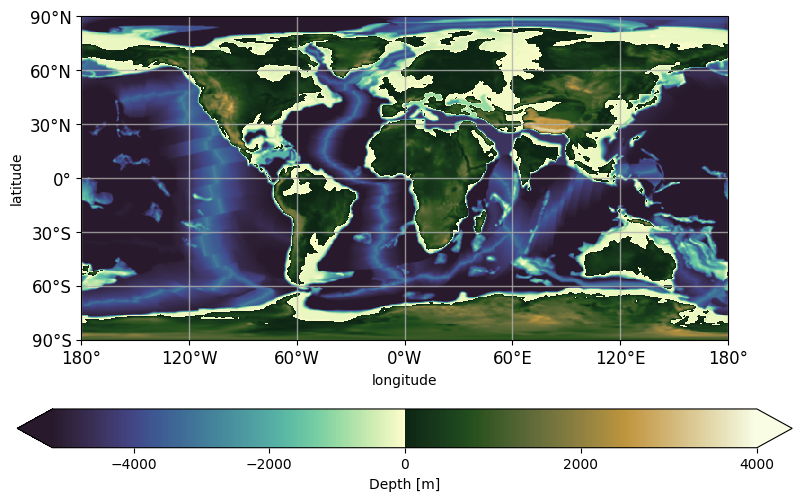

In [73]:
#check by pcolormesh
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
norm = TwoSlopeNorm(vcenter=0., vmin=-5200, vmax=4000)

im = ax.pcolormesh(lon,lat,bathy_raw ,cmap=cmocean.cm.topo,transform=ccrs.PlateCarree()
    ,norm=norm                )
# im = ax.contourf(lon,lat,bathy_raw, cmap=cmocean.cm.topo,norm=norm,levels=np.linspace(-5200,0,53), extend='min')


ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# ax.set_title('Bathymetry_'+str(filename_bathy))

cb=fig.colorbar(im, ax=ax, extend='both',orientation='horizontal')
cb.set_label("Depth [m]")
#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

plt.show()

In [25]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

In [16]:
# @njit(cache=True)
def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.array([lonlat_to_xyz(lon, lat) for lon, lat in flattened_XCYC1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

            # ノルムを計算（geopy を使用）
            for k in range(l):
                lon1, lat1 = XCYC1[top_l_indices[i, j, k, 0], top_l_indices[i, j, k, 1]]
                lon2, lat2 = XCYC2[i, j, 0], XCYC2[i, j, 1]

                top_l_norms[i, j, k] = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    return top_l_indices, top_l_norms


In [15]:
@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2.):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    l = top_l_indices.shape[2]  # 最近傍点の数
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) #when unit is deg, worked well.


    return regridded_data


In [ ]:
#Directory for cs grid
fileloc_csgrid = '/home/tsuribeh/MITgcm/cases_tsuribeh/cpl_aim+ocn_cs32/rank_1/'
# CSグリッドデータの読み込み
XC = mit.mds.rdmds(fileloc_csgrid+'XC') #longitude at cell center
YC = mit.mds.rdmds(fileloc_csgrid+'YC') #latitude at cell center
XG = mit.mds.rdmds(fileloc_csgrid+'XG')
YG = mit.mds.rdmds(fileloc_csgrid+'YG')
# RC = mit.mds.rdmds(fileloc_csgrid+'RC')  # セル中心の深さ can be changed
# RF = mit.mds.rdmds(fileloc_csgrid+'RF')  # セル境界の深さ can be changed

# fileloc_latlondata ='/home/tsuribeh/MITgcm/cases_tsuribeh/global_ocean.cs32x15_originalbathy/input/latlon_inputdata/'

XCYC = np.stack([XC,YC],axis=2)
XGYG = np.stack([XG,YG],axis=2)


#compute indice and norm for regridding
top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=4)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=4)


In [21]:
XCYC = np.stack([XC,YC],axis=2)
XGYG = np.stack([XG,YG],axis=2)


In [26]:
#compute indice and norm for regridding
top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=4)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=4)

#regrid bathy data to CS
bathy_regridded = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,bathy_raw,p=2.)

In [14]:
#re-regrid for verification
bathy_re_regridded = regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,bathy_regridded,p=2.)

#check difference 
difference = bathy_re_regridded -bathy_raw

print('Max difference',np.abs(difference).max())
print('Min difference',np.abs(difference).min())
print('RMSE',np.linalg.norm(np.array(difference).flatten())/len(np.array(difference).flatten())**0.5)





Max difference nan
Min difference nan
RMSE nan


Text(0, 0.5, 'latitude')

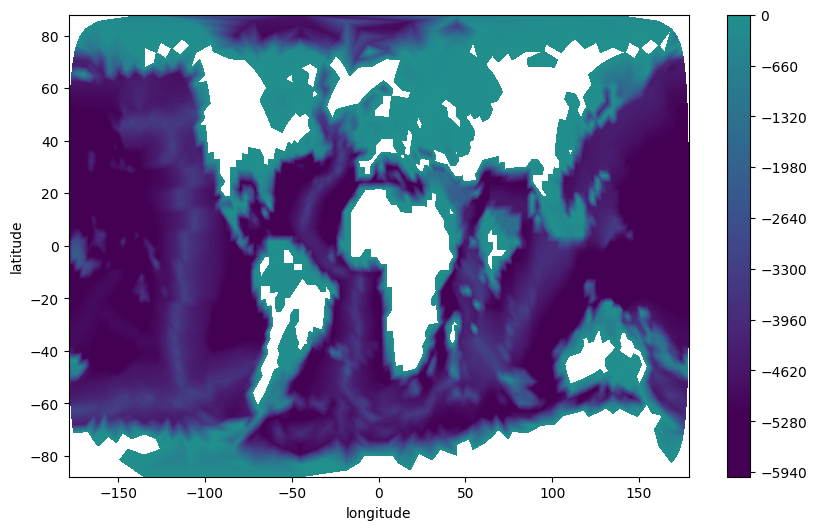

In [15]:
bathy_regridded[np.isnan(bathy_regridded)] = 0.
fig = plt.figure(figsize=(10,6)) # プロット領域の作成（matplotlib）
ax=fig.add_subplot(111)
# bmax=np.max(np.abs(bathy_regridded))
im= ax.tricontourf(XC.flatten(),YC.flatten(),bathy_regridded.flatten(),
            #    cmap=cmocean.cm.topo,
               norm=norm,levels=100
               )
fig.colorbar(im, ax=ax)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')


最小 RMSE: 534.7517869609829
最適な l: 4
最適な p: 2

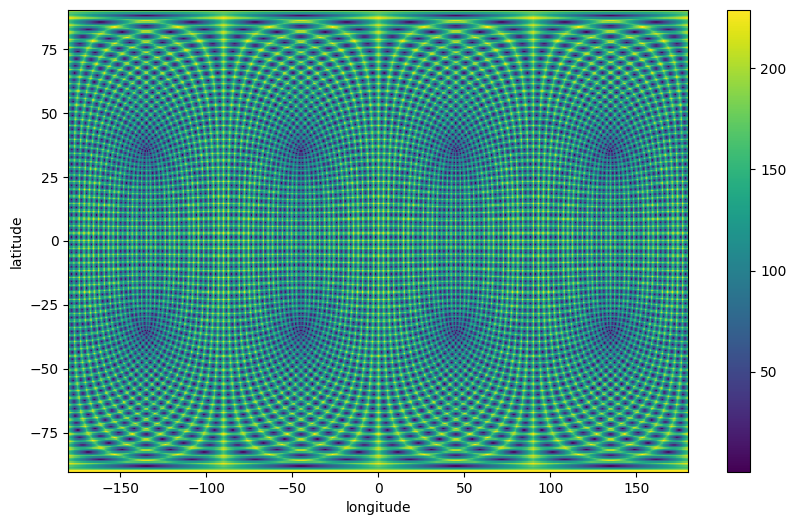

228.98805317338187


In [16]:
#check  distance by pcolormesh
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
norm = TwoSlopeNorm(vcenter =0)

# im = ax.pcolormesh(lon,lat,bathy_raw, cmap=cmocean.cm.topo,norm=norm)
im = ax.pcolormesh(lon,lat,top_norms_XCYC_to_lonlat.min(axis=2))

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

fig.colorbar(im, ax=ax)
plt.show()

print(top_norms_XCYC_to_lonlat.min(axis=2).max())

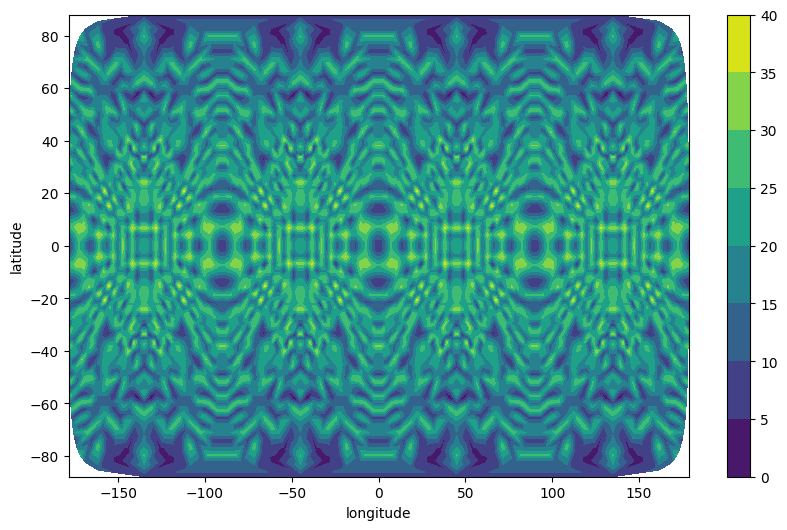

0.4889910134995203
37.13150475310821
7.683603626011705
64.70831759699776


In [17]:
#check by pcolormesh
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
norm = TwoSlopeNorm(vcenter =0)

# im = ax.pcolormesh(lon,lat,bathy_raw, cmap=cmocean.cm.topo,norm=norm)
im = ax.tricontourf(XC.flatten(),YC.flatten(),top_norms_lonlat_to_XCYC.min(axis=2).flatten())

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

fig.colorbar(im, ax=ax)
plt.show()
print(top_norms_lonlat_to_XCYC.min(axis=2).min())
print(top_norms_lonlat_to_XCYC.min(axis=2).max())
print(top_norms_lonlat_to_XCYC.max(axis=2).min())
print(top_norms_lonlat_to_XCYC.max(axis=2).max())



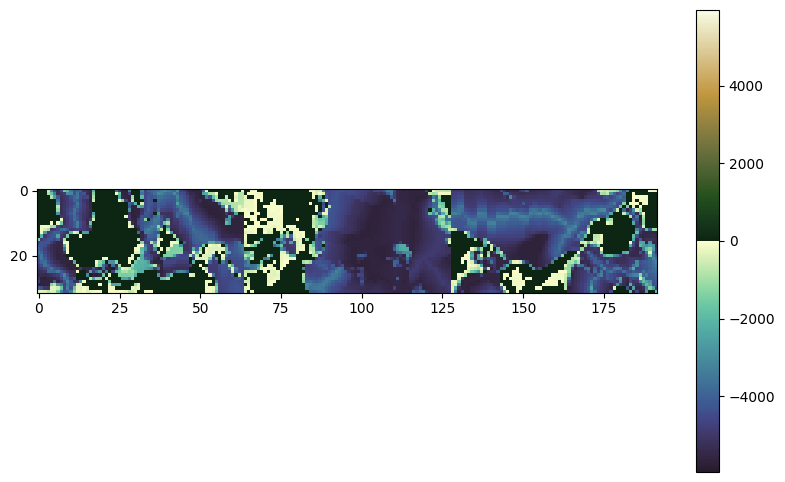

In [18]:
#check by imshow
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
norm = TwoSlopeNorm(vcenter =0)
im = ax.imshow(bathy_regridded, cmap=cmocean.cm.topo,norm=norm)

fig.colorbar(im, ax=ax)
plt.show()

In [43]:
bathy_ETOPO1= mit.readbin(fileloc_go_input+'ETOPO1_cs32_ocn.bin',(32,192),'float64')
bathy_default = mit.readbin(fileloc_go_input+'bathy_cs32.bin',(32,192),'float64') #default bathymetry

In [44]:
delR = np.array([50., 70., 100., 140., 190.,
       240., 290., 340., 390., 440.,
       490., 540., 590., 640., 690.]) #edit here acording to /input/data
depth_F = np.append(0,-1*delR).cumsum()
depth_C = (depth_F[1:] + depth_F[:-1])*0.5

delR_default = np.array([50., 70., 100., 140., 190.,
       240., 290., 340., 390., 440.,
       490., 540., 590., 640., 690.]) 
depth_F_default = np.append(0,-1*delR_default).cumsum()
depth_C_default = (depth_F_default[1:] + depth_F_default[:-1])*0.5

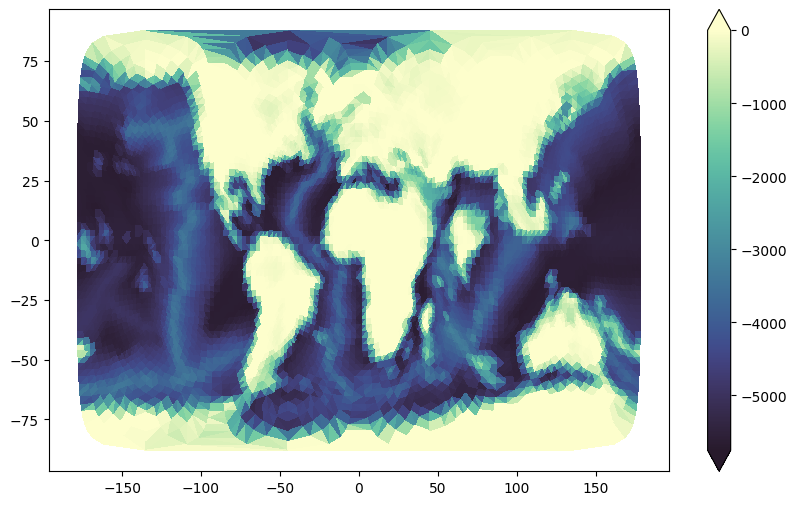

FileNotFoundError: [Errno 2] No such file or directory: '/home/tsuribeh/MITgcm/cases_tsuribeh/Straume2020_go.cs32x15/input_test/Straume20_St50Ma_cs32.bin'

In [45]:
bathy_regridded[bathy_regridded > 0.] = 0.
# mask_bathy2 = (bathy_regridded <0.) & (bathy_regridded>depth_F[1])
# bathy_regridded[mask_bathy2] = 0.     #not calculate if shallower than 1st layer

#check by imshow
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# norm = TwoSlopeNorm(vcenter =0)
# im= ax.tricontourf(XC.flatten(),YC.flatten(),bathy_regridded.flatten(),
#             #    cmap=cmocean.cm.deep_r,
#                levels=100
#                )
im= ax.tripcolor(XC.flatten(),YC.flatten(),bathy_regridded.flatten(),
               cmap=cmocean.cm.deep_r,
               )
fig.colorbar(im, ax=ax, extend='both')
plt.show()
mit.writebin(fileloc_to_write + filename_bathy, bathy_regridded,dataprec='float64')
# fileloc_go_input+'hydrogSalt_avgd_ETOPO1.bin',hydrogSalt_avgd,dataprec='float64'

In [46]:



bathymask= np.ones((len(depth_F)-1,32,192))
bathymask_default = np.ones((len(depth_F_default)-1,32,192))

for k in range(len(depth_F)-1):
    bathymask[k] =np.where(bathy_regridded >= depth_F[k],0.,1.)

for k in range(len(depth_C_default)):
    bathymask_default[k] =np.where(bathy_default >= depth_F_default[k],0.,1.)


depth_C

array([  -25.,   -85.,  -170.,  -290.,  -455.,  -670.,  -935., -1250.,
       -1615., -2030., -2495., -3010., -3575., -4190., -4855.])

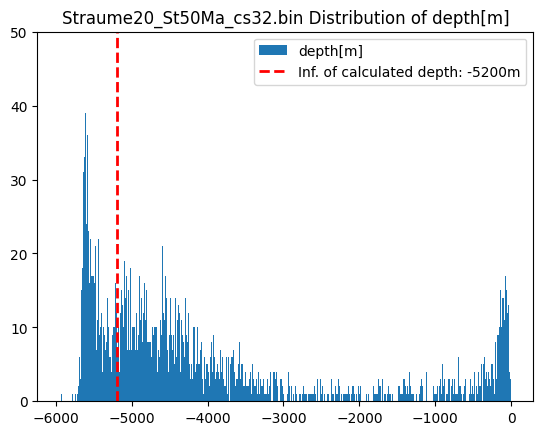

In [24]:
dhist_data = bathy_regridded[bathy_regridded <0.].flatten()

fig= plt.figure()
ax= fig.add_subplot(111)
ax.hist(dhist_data,bins=1000,label='depth[m]')
ax.axvline(depth_F[-1], linestyle='--', color='red',linewidth=2, label=f'Inf. of calculated depth: {depth_F[-1]:.0f}m')
ax.set_ylim(0,50)
ax.legend()
ax.set_title(str(filename_bathy)+' Distribution of depth[m]')
plt.show()

In [25]:
bathymask.shape

(15, 32, 192)

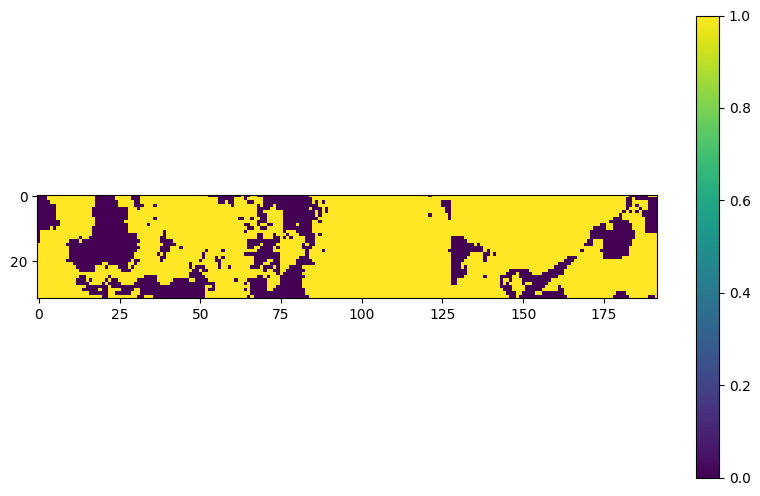

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
# im = ax.contourf(lon, lat, thetaClim_latlon[5, :, :], cmap=cmocean.cm.thermal)
im = ax.imshow(bathymask[0])
# カラーバーを追加
fig.colorbar(im, ax=ax)
# プロットを表示
plt.show()


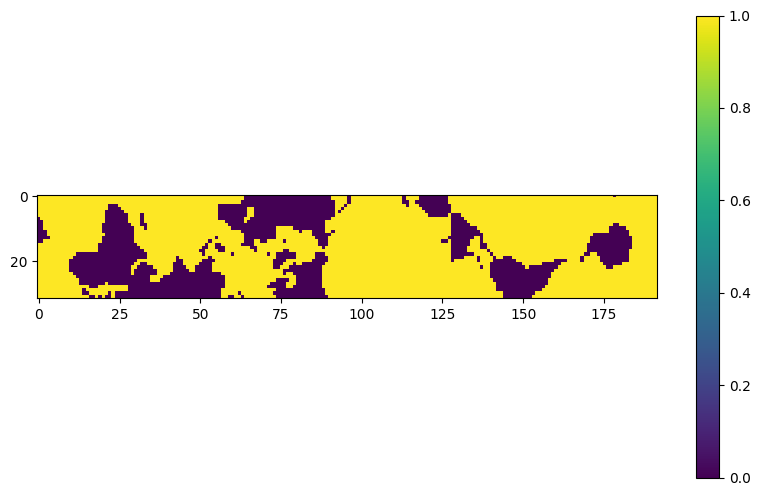

In [27]:
condition_land_default = bathy_default >= 0
landmask_default =np.where(condition_land_default,np.nan,1.)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# データをプロット
# im = ax.contourf(lon, lat, thetaClim_latlon[5, :, :], cmap=cmocean.cm.thermal)
# im = ax.imshow(landmask_default)
im = ax.imshow(bathymask_default[0])

# カラーバーを追加
fig.colorbar(im, ax=ax)
# プロットを表示
plt.show()


In [28]:
#set initial salt & temperature file
hydrogTheta= mit.readbin(fileloc_go_input+'lev_T_cs_15k.bin',(15,32,192),'float64')
hydrogSalt= mit.readbin(fileloc_go_input+'lev_S_cs_15k.bin',(15,32,192),'float64')
mask_initTS_default = hydrogSalt== 0.
hydrogSalt[mask_initTS_default] =np.nan
hydrogTheta[mask_initTS_default] = np.nan

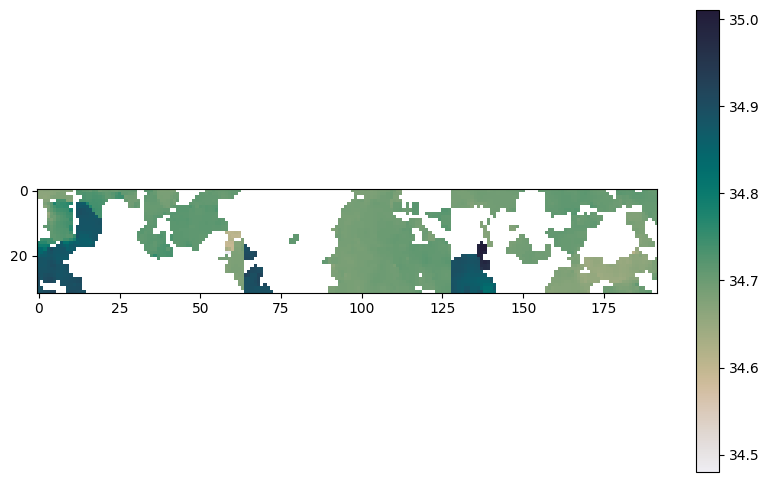

nan

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
im = ax.imshow(hydrogSalt[-1], cmap=cmocean.cm.rain)
# カラーバーを追加
fig.colorbar(im, ax=ax)
# プロットを表示
plt.show()
hydrogSalt[0,20,25]

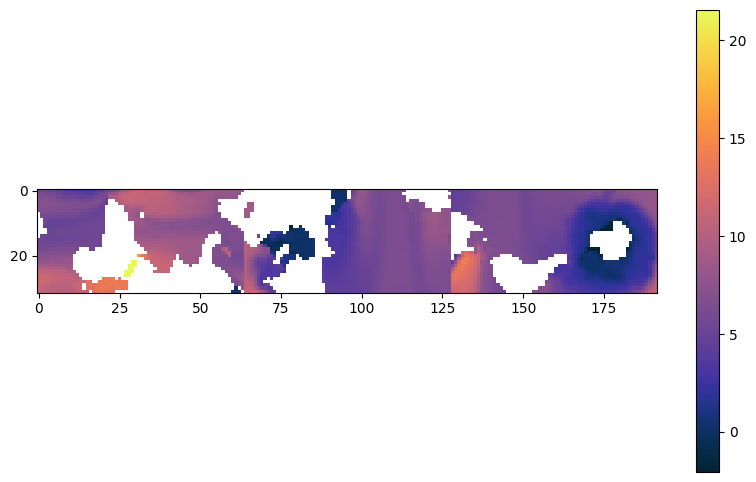

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
im = ax.imshow(hydrogTheta[5], cmap=cmocean.cm.thermal)
# カラーバーを追加
fig.colorbar(im, ax=ax)
# プロットを表示
plt.show()

In [31]:
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)
# # データをプロット
# im = ax.imshow(hydrogSalt[0]*bathymask_default[0], cmap=cmocean.cm.rain)
# # カラーバーを追加
# fig.colorbar(im, ax=ax)
# # プロットを表示
# plt.show()

In [32]:
# hydrogSalt_mean = 0.
# hydrogSalt_min = 0.

# hydrogtheta_mean = 0.

# for k in range(len(delR)):
#     hydrogSalt_mean += np.nanmean(hydrogSalt[k])*delR[k]
#     hydrogSalt_min += np.nanmin(hydrogSalt[k])*delR[k]

#     hydrogtheta_mean += np.nanmean(hydrogTheta[k])*delR[k]

# hydrogSalt_mean /= sum(delR)
# hydrogSalt_min /= sum(delR)

# hydrogtheta_mean /= sum(delR)
# print(hydrogSalt_mean)
# print(hydrogtheta_mean)
# print(hydrogSalt_min)


水温は平均値(3.075682729509555)
塩分は33を初期値とする(2025/1/24~)。
→始新世前期を再現したSST場に対しては小さすぎるため、水温も一律30℃に変更。（2025/1/25~）
→12℃に変更（1/27）
→収束性が悪いため、水温：一律33度、塩分12‰に変更(2/16)

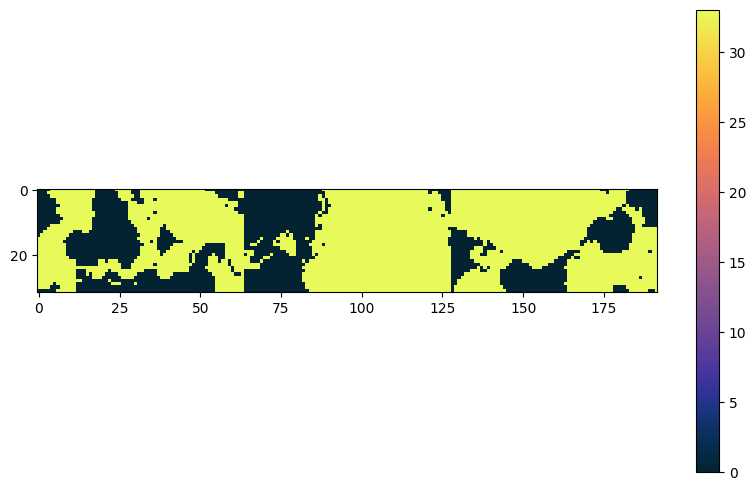

In [33]:
hydrogTheta_avgd =  np.empty_like(hydrogTheta)
hydrogTheta_avgd[:,:] =  33.#12.

hydrogTheta_avgd = hydrogTheta_avgd*bathymask #mask land

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
im = ax.imshow(hydrogTheta_avgd[6], cmap=cmocean.cm.thermal)
# カラーバーを追加
fig.colorbar(im, ax=ax)
# プロットを表示
plt.show()

mit.writebin(fileloc_to_write+filename_hydrogTheta, hydrogTheta_avgd, dataprec='float64')



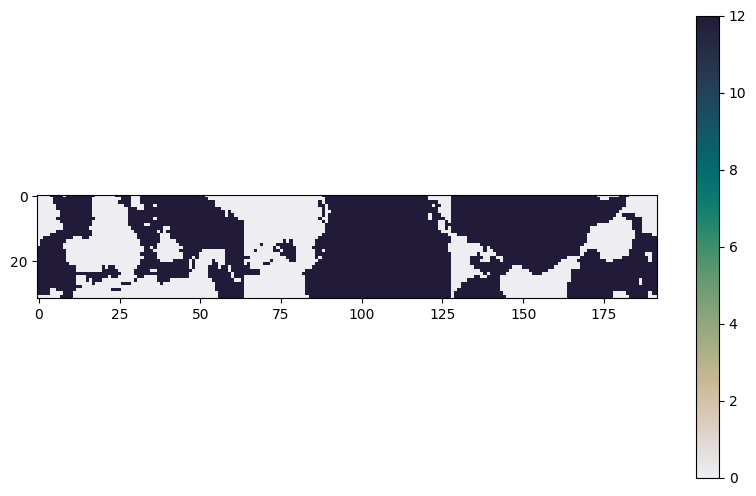

In [34]:
hydrogSalt_avgd =  np.empty_like(hydrogSalt)
# hydrogSalt_avgd[:,:] =   hydrogSalt_mean
hydrogSalt_avgd[:,:] =   12.#33.


hydrogSalt_avgd =  hydrogSalt_avgd*bathymask
hydrogSalt_avgd[np.isnan(hydrogSalt_avgd)] = 0.

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
im = ax.imshow(hydrogSalt_avgd[-6], cmap=cmocean.cm.rain)
# カラーバーを追加
fig.colorbar(im, ax=ax)
# プロットを表示
plt.show()

mit.writebin(fileloc_to_write+filename_hydrogSalt, hydrogSalt_avgd*bathymask, dataprec='float64')


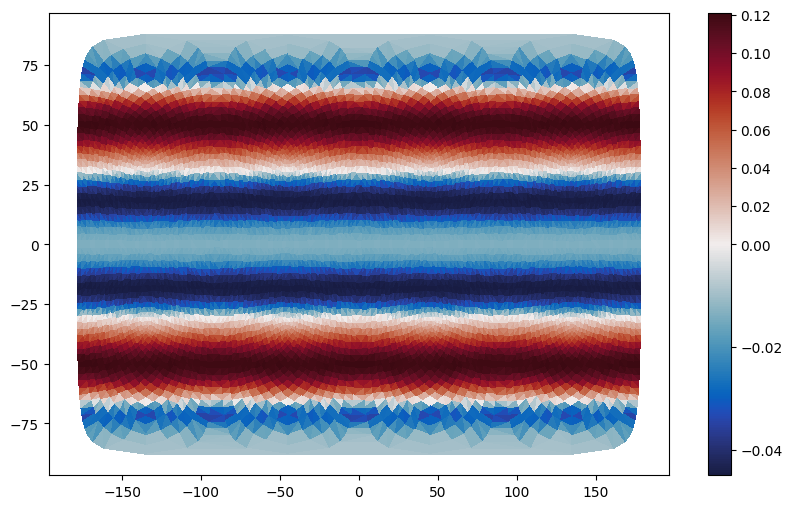

In [18]:
zonalWind = mit.readbin(fileloc_go_input+'TauX_trenberth_polar_averaged_sym.bin',(12,32,192),'float64')
# zonalWind = mit.readbin(fileloc_go_input+'TauX_trenberth_polar_averaged_asym.bin',(12,32,192),'float64')

# 正規化: カラーマップの中心を 0 に設定
norm = TwoSlopeNorm(vcenter=0)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# データをプロット
im = ax.tripcolor(XC.flatten(), YC.flatten(), zonalWind[0].flatten(), cmap=cmocean.cm.balance, norm=norm)
# im = ax.pcolormesh(lon, lat, meridWind_latlon_avg, cmap='jet', vmax=0.2,vmin=-0.2)


# カラーバーを追加
fig.colorbar(im, ax=ax)

# プロットを表示
plt.show()

CSのデフォルトの東西風応力は弱すぎたため、東西風のみ極座標のチュートリアルからデータを持ってきている。

In [20]:
zonalWind_regrid= [regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,zonalWind[_].astype('<f8'),p=2.) for _ in range(12)]
# zonalWind_regrid= [regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,zonalWind[_].astype('<f8'),p=2.) for _ in range(2)] #季節変化考えるとき

zonalWind_regrid = np.array(zonalWind_regrid)
plt.plot(lat[:,60], zonalWind_regrid[0,:,60] )


NameError: name 'XCYC' is not defined

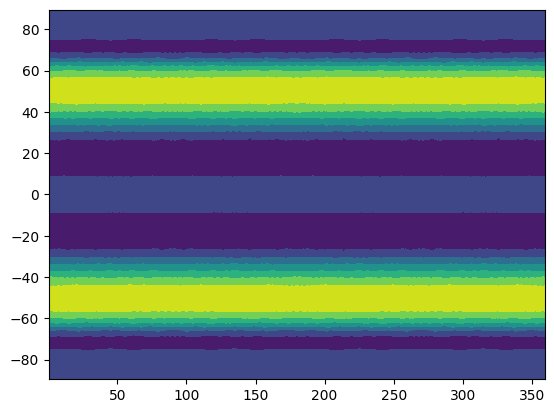

In [77]:
plt.contourf(lon_,lat_, zonalWind_regrid[0])

In [37]:
zonalWind[:2].shape

(2, 32, 192)

In [38]:
# mit.writebin(fileloc_to_write+filename_TauX,zonalWind,dataprec='float64')
mit.writebin(fileloc_to_write+filename_TauX,zonalWind[:2],dataprec='float64') #季節変化考えるとき


In [39]:
zonalwind_cv = zonalWind_regrid[0,:,:]
zonalwind_cv.shape

(361, 721)

In [40]:
dTauXdy =np.zeros_like(lat)
dTauXdy.shape

(361, 721)

In [41]:
# # zonalwind_cv = zonalWind_regrid[0,:,:]
# # zonalwind_cv = np.append(zonalWind_regrid[0,-1,:], zonalwind_cv)

# dTauXdy =np.zeros_like(lat)

# from geopy.distance import great_circle
# for j in range(dTauXdy.shape[0]-1):
#     for i in range(1,dTauXdy.shape[1]-1):
#         dTauXdy[i,j] =( (zonalwind_cv[j,i+1]-zonalwind_cv[j,i])/great_circle((lat_[j],lon_[i+1]), (lat_[j],lon_[i])).m +
#                     (zonalwind_cv[j,i]-zonalwind_cv[j,i-1])/great_circle((lat_[j],lon_[i]), (lat_[j],lon_[i-1])).m 
#         )*0.5



In [42]:
# # dTauXdy 配列の初期化
# dTauXdy = np.zeros_like(zonalwind_cv)

# # ループの開始と終了位置を調整
# for j in range(1, dTauXdy.shape[0] - 1):  # 緯度方向
#     for i in range(1, dTauXdy.shape[1] - 1):  # 経度方向
#         dTauXdy[j, i] = (
#             ((zonalwind_cv[j+1, i] - zonalwind_cv[j, i]) /
#             great_circle((lat_[j+1], lon_[i]), (lat_[j], lon_[i])).m )+
#             ((zonalwind_cv[j, i] - zonalwind_cv[j-1, i]) /
#             great_circle((lat_[j], lon_[i]), (lat_[j-1], lon_[i])).m)
#         ) * 0.5
#     #  dTauXdy[j, i] = (zonalwind_cv[j+1,i]- zonalwind_cv[j-1, i]) / great_circle((lat_[j+1],lon_[i]),(lat_[j-1], lon_[i])).m
        


/home/tsuribeh/.local/lib/python3.10/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/tmp/ipykernel_483961/3123232055.py:9: RankWarning: Polyfit may be poorly conditioned
  TauX_cf = np.polyfit(lat_,zonalwind_cv[:,1],deg=i)


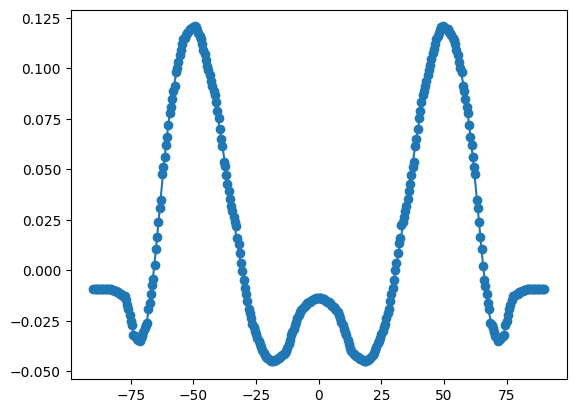

In [43]:
RMSE_TauX =[1]
i=157 #minimise RMSE

# while RMSE_TauX[-1] > zonalwind_cv.max()*1.e-3:
#     TauX_cf = np.polyfit(lat_,zonalwind_cv[:,1],deg=i)
#     RMSE_TauX.append((np.linalg.norm(np.polyval(TauX_cf,lat_) - zonalwind_cv[:,1])/np.size(zonalwind_cv[:,1])**0.5))
#     i += 1

TauX_cf = np.polyfit(lat_,zonalwind_cv[:,1],deg=i)


plt.plot(lat_,np.polyval(TauX_cf,lat_))
plt.scatter(lat_,zonalwind_cv[:,1] )

In [44]:
RMSE_TauX

[1]

In [45]:
del_TauX_cf = np.polyder(TauX_cf)

In [46]:
dTauXdy_2 = np.polyval(del_TauX_cf,lat)

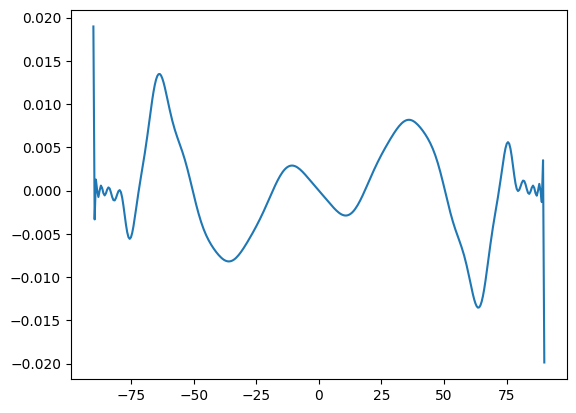

In [47]:
plt.plot(lat[:,60],dTauXdy_2[:,60])


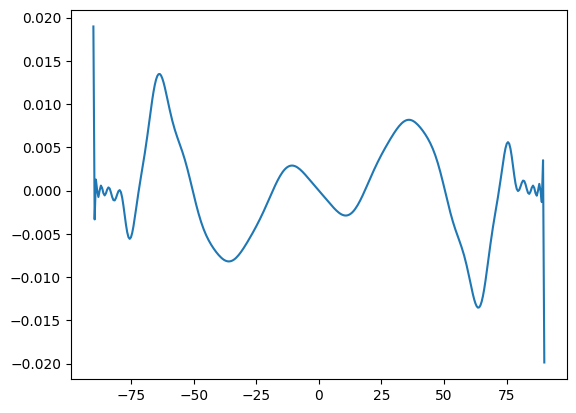

In [48]:
# dTauXdy_2[0,:] =0.
# dTauXdy_2[-1,:] =0.
# dTauXdy_2[1,:] =0.
# dTauXdy_2[-2,:] =0.
# dTauXdy_2[2,:] =0.
# dTauXdy_2[-3,:] =0.
# dTauXdy_2[3,:] =0.
# dTauXdy_2[-4,:] =0.
# dTauXdy_2[4,:] =0.
# dTauXdy_2[-5,:] =0.
# dTauXdy_2[5,:] =0.
# dTauXdy_2[-6,:] =0.
# dTauXdy_2[6,:] =0.
# dTauXdy_2[-7,:] =0.
# dTauXdy_2[7,:] =0.
# dTauXdy_2[-8,:] =0.
# dTauXdy_2[8,:] =0.
# dTauXdy_2[-9,:] =0.
# dTauXdy_2[9,:] =0.
# dTauXdy_2[-10,:] =0.

plt.plot(lat[:,60],dTauXdy_2[:,60])


In [49]:
dTauXdy.shape

(361, 721)

In [50]:
# plt.plot(lat[:,60], dTauXdy[:,60] *1.e7)


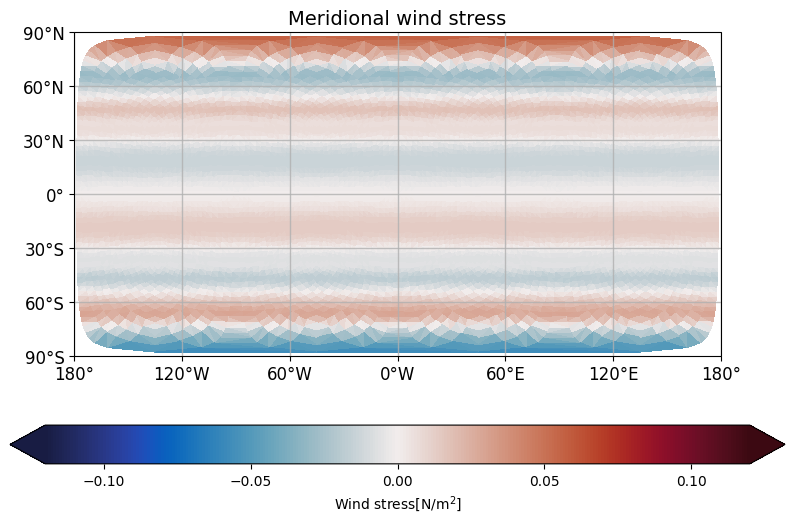

In [97]:
# meridWind = mit.readbin(fileloc_go_input+'TauY_trenberth_averaged_asym.bin',(12,32,192),'float64')
meridWind = mit.readbin(fileloc_go_input+'TauY_trenberth_averaged_antisym.bin',(12,32,192),'float64')


# 正規化: カラーマップの中心を 0 に設定
norm = TwoSlopeNorm(vcenter=0)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# データをプロット
im = ax.tripcolor(XC.flatten(), YC.flatten(), meridWind[0].flatten(), cmap=cmocean.cm.balance,vmax=0.12,vmin=-0.12
                  )
# im = ax.pcolormesh(lon, lat, meridWind_latlon_avg, cmap='jet', vmax=0.2,vmin=-0.2)
cb = fig.colorbar(im, ax=ax, orientation="horizontal",extend='both')
cb.set_label('Wind stress[N/m$^2$]')





#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)
# タイトルと表示
ax.set_title("Meridional wind stress", fontsize=14)

# ax.legend()
plt.show()


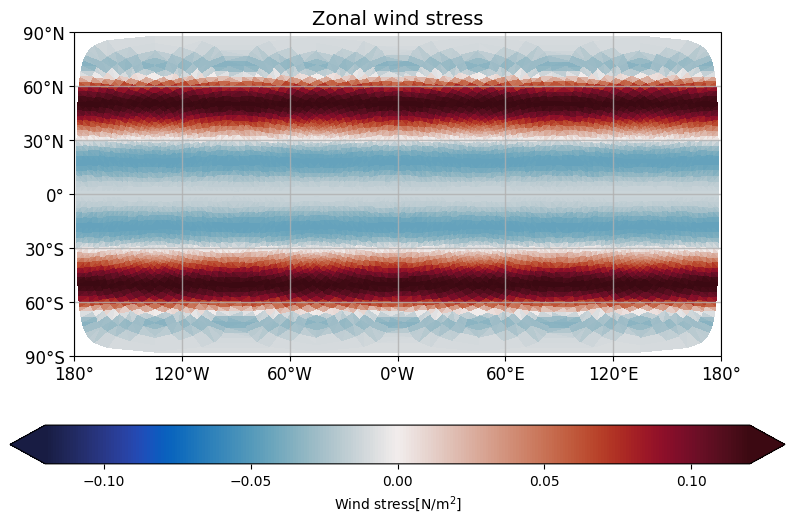

In [96]:
# meridWind = mit.readbin(fileloc_go_input+'TauY_trenberth_averaged_asym.bin',(12,32,192),'float64')
meridWind = mit.readbin(fileloc_go_input+'TauY_trenberth_averaged_antisym.bin',(12,32,192),'float64')


# 正規化: カラーマップの中心を 0 に設定
norm = TwoSlopeNorm(vcenter=0)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# データをプロット
im = ax.tripcolor(XC.flatten(), YC.flatten(), zonalWind[0].flatten(), cmap=cmocean.cm.balance,vmin = -0.12, vmax=0.12)
# im = ax.pcolormesh(lon, lat, meridWind_latlon_avg, cmap='jet', vmax=0.2,vmin=-0.2)
cb = fig.colorbar(im, ax=ax, orientation="horizontal",extend='both')
cb.set_label('Wind stress[N/m$^2$]')





#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)
# タイトルと表示
ax.set_title("Zonal wind stress", fontsize=14)


# ax.legend()
plt.show()


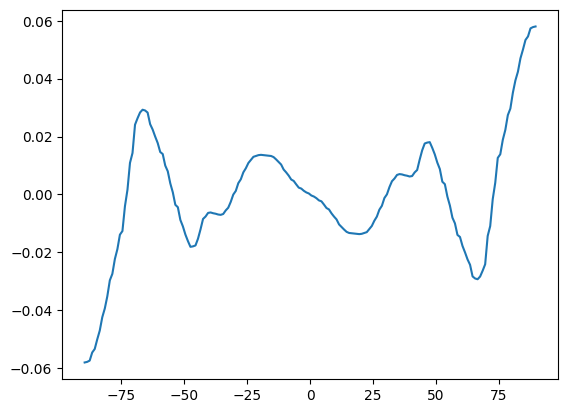

In [79]:
meridWind_regrid= np.array([regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,meridWind[_].astype('<f8'),p=2.) for _ in range(12)])
plt.plot(lat[:,60], meridWind_regrid[0,:,60] )


In [53]:
mit.writebin(fileloc_to_write+filename_TauY,meridWind[:2],dataprec='float64')

東西風、南北風はOK

In [54]:
zonalWind_regrid.shape

(2, 361, 721)

In [74]:
# lon__ = np.linspace(-180,180,361) #4deg
lon__ = np.linspace(0,360,361) #4deg

lat__ = np.linspace(-90,90,181) #4deg
lon_ = (lon__[1:]+lon__[:-1])*0.5  #cell center
lat_ = (lat__[1:] + lat__[:-1])*0.5
lon,lat = np.meshgrid(lon_,lat_)
lonlat = np.stack([lon,lat],axis=2)
lat_distance = np.empty_like(lat)
lon_distance = np.empty_like(lon)

for j in range(lat.shape[0]):
    for i in range(lon.shape[1]):
        # print('i:',i)
        lat_distance[j,i] = great_circle((lat__[j+1],lon_[i]),(lat__[j],lon_[i])).meters 
        lon_distance[j,i] = great_circle((lat_[j],lon__[i+1]),(lat_[j],lon__[i])).meters
    # print('j:',j)
    

# dVol_c_lonlat = lon_distance*lat_distance

#compute indice and norm for regridding
top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=4)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=4)


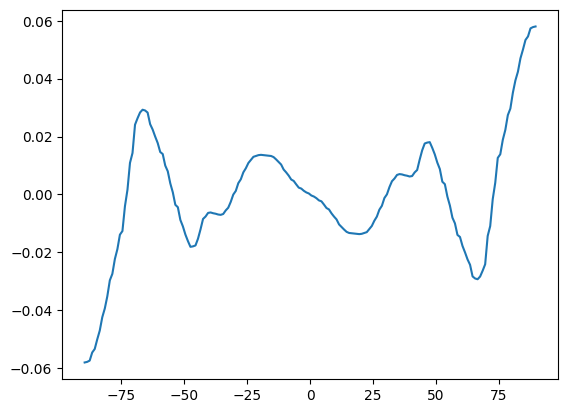

In [80]:
meridWind_regrid= np.array([regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,meridWind[_].astype('<f8'),p=2.) for _ in range(12)])
plt.plot(lat[:,60], meridWind_regrid[0,:,60] )


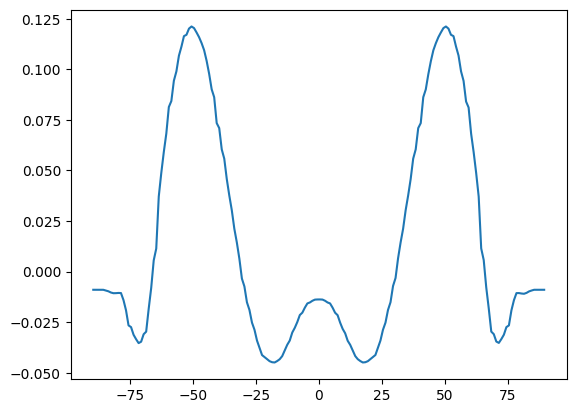

In [81]:
# zonalWind_regrid= [regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,zonalWind[_].astype('<f8'),p=2.) for _ in range(12)]
zonalWind_regrid= [regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,zonalWind[_].astype('<f8'),p=2.) for _ in range(2)] #季節変化考えるとき

zonalWind_regrid = np.array(zonalWind_regrid)
plt.plot(lat[:,60], zonalWind_regrid[0,:,60] )


TypeError: Dimensions of C (361, 721) should be one smaller than X(360) and Y(180) while using shading='flat' see help(pcolormesh)

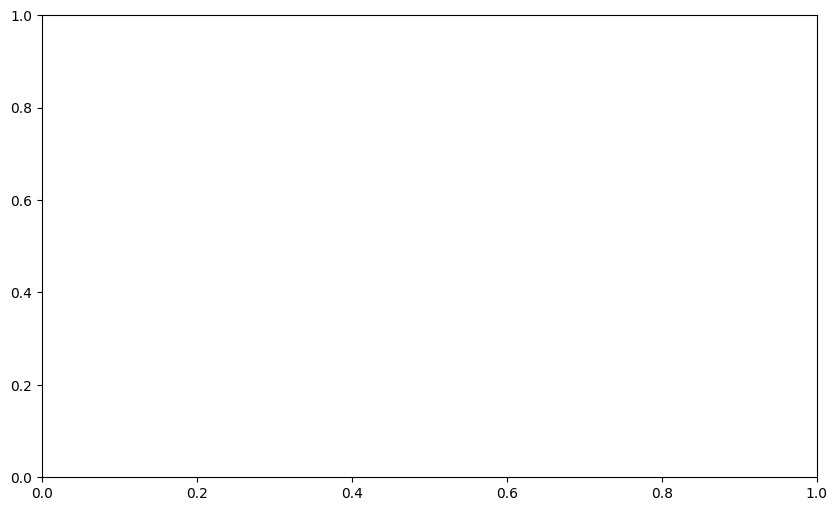

In [83]:
# 正規化: カラーマップの中心を 0 に設定
# norm = TwoSlopeNorm(vcenter=0)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# データをプロット
R_earth=6370.e3
# im = ax.pcolormesh(lon[1:-1], lat[1: -1], -dTauXdy[1:-1]*1.e7 #R_earth
#                   ,cmap=cmocean.cm.curl)

im = ax.pcolormesh(lon, lat, -dTauXdy_2#*1.e7 #R_earth
                #  ,levels=100 
                 ,cmap=cmocean.cm.curl)

# im = ax.pcolormesh(lon[1:-1], lat[1: -1], -dTauXdy[1:-1], cmap=cmocean.cm.curl)


# quiver= ax.quiver(lon[::40,::60],lat[::40,::60],zonalWind_regrid[0][::40,::60],meridWind_regrid[0][::40,::60],
#                   headwidth=5.0, pivot='mid', angles='xy', headaxislength=2. ,linewidth=0.3, edgecolor='gray',color='black'
#                   )

quiver= ax.quiver(lon[::1,::1],lat[::1,::1],zonalWind_regrid[0][::1,::1],meridWind_regrid[0][::1,::1],
                  headwidth=5.0, pivot='mid', angles='xy', headaxislength=2. ,linewidth=0.3, edgecolor='gray',color='black'
                  )

quiverkey = ax.quiverkey(quiver, 0.01, -0.15, 0.1, label='0.1 N/m$^2$', edgecolor='gray',color='black', labelsep=0.05,linewidth=0.3
                         )
ax.set_xlabel('Longitude[$^\circ$]')
ax.set_ylabel('Latitude[$^\circ$]')

# グリッドの追加
ax.grid(True)
# カラーバーを追加
cb = fig.colorbar(im, ax=ax, extend='both',orientation='horizontal')
cb.set_label('Approximate wind stress curl [x 10$^{-7}$ N/m$^3$]')

# プロットを表示
ax.set_title('Wind stress')
plt.show()

SSTの緩和強制力を作成

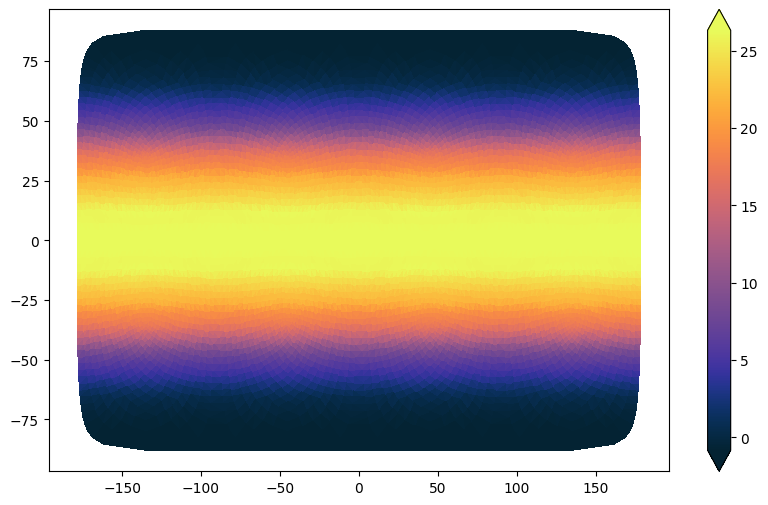

In [1350]:
thetaClim = mit.readbin(fileloc_go_input+'SST_lev_polar_sym.bin',(12,32,192),'float64')
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
thetaClim_plot = thetaClim[0]
# thetaClim_plot[np.isnan(landmask_default)] = np.nan
im = ax.tripcolor(XC.flatten(),YC.flatten(),thetaClim_plot.flatten(), cmap=cmocean.cm.thermal)
# カラーバーを追加
fig.colorbar(im, ax=ax,extend='both')
# プロットを表示
plt.show()

In [1351]:
thetaClim.min()

-0.8442730299655801

(上)CSのデフォルトのSSTデータ（気候値）を年平均し、南北対称にしたもの。

In [1352]:
thetaClim = mit.readbin(fileloc_go_input+'SST_lev_polar_sym.bin',(12,32,192),'float64')

# # sstcoeff = np.array([-3.52684192e-03,  1.24645899e-01,  2.95118796e+01])#Paleo_SST_setting.ipynbよりTcoef_38Maをコピー
sstcoeff=np.array([-1.46723647e-03,  0.00000000e+00,  3.00059524e+01]) #Paleo_SST_setting.ipynbよりTcoef_EECOをコピー
# sstcoeff =np.array([-3.64991886e-03,  1.17631954e-16,  3.01182783e+01]) #Paleo_SST_setting.ipynbよりTcoef_mideoceneをコピー
thetaClim_latlon= np.polyval(sstcoeff,lat)


# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)
# # データをプロット
# thetaClim_plot = thetaClim_latlon
# # thetaClim_plot[np.isnan(landmask_default)] = np.nan
# im = ax.tripcolor(lon.flatten(),lat.flatten(),thetaClim_plot.flatten(), cmap=cmocean.cm.thermal,vmin=0.,vmax=30.
#                   )
# # カラーバーを追加
# fig.colorbar(im, ax=ax,extend='max')
# # プロットを表示
# plt.show()

In [1353]:
thetaClim_regridded = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,thetaClim_latlon)

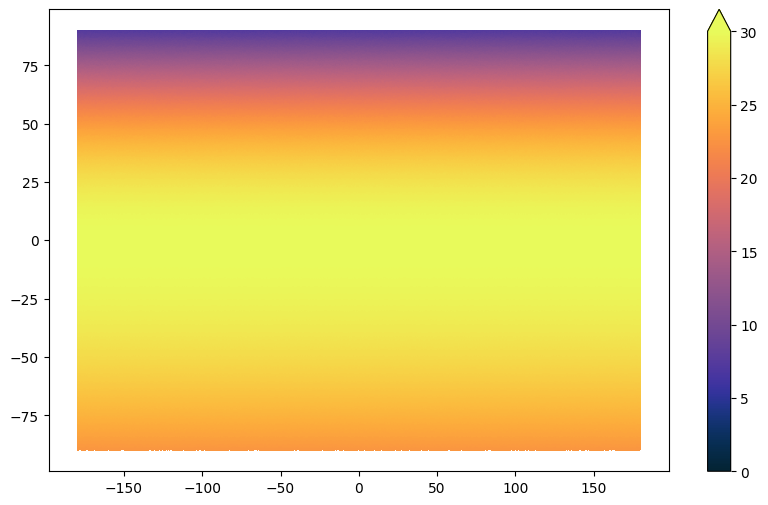

In [1354]:
#Early eoceneに季節変化を入れる
sstcoeff_wn = np.array([-9.00491407e-04,  0.00000000e+00,  3.00058190e+01])
sstcoeff_sm = np.array([-2.81340922e-03,  0.00000000e+00,  3.00058190e+01])
thetaClim_latlon_season = np.empty_like(lat)
thetaClim_latlon_season[:len(thetaClim_latlon)//2 -1] = np.polyval(sstcoeff_wn, lat[:len(lat)//2-1])
thetaClim_latlon_season[len(thetaClim_latlon)//2-1:] = np.polyval(sstcoeff_sm, lat[len(lat)//2 -1:])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
thetaClim_plot = thetaClim_latlon_season
# thetaClim_plot[np.isnan(landmask_default)] = np.nan
im = ax.tripcolor(lon.flatten(),lat.flatten(),thetaClim_plot.flatten(), cmap=cmocean.cm.thermal,vmin=0.,vmax=30.
                  )
# カラーバーを追加
fig.colorbar(im, ax=ax,extend='max')
# プロットを表示
plt.show()


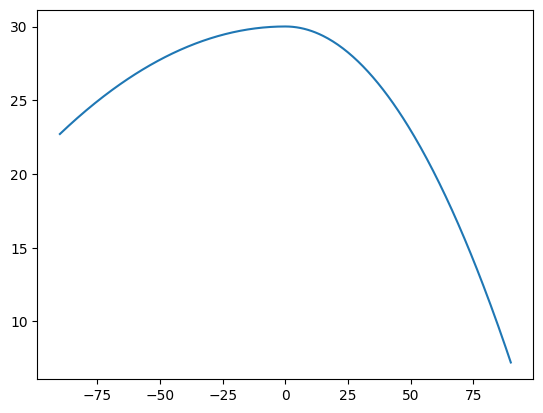

In [1355]:
plt.plot(lat[:,60], thetaClim_latlon_season[:,60] )


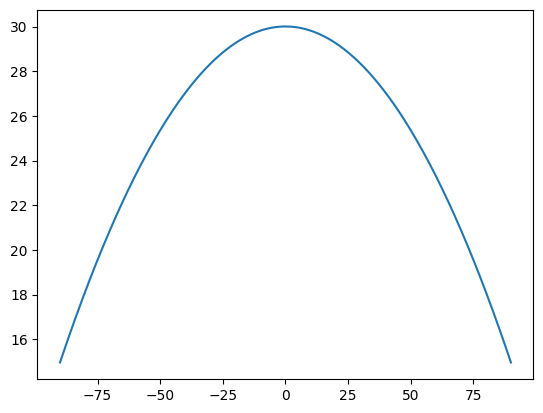

In [1356]:
plotdata = (thetaClim_latlon_season+ np.flipud(thetaClim_latlon_season))*0.5
plt.plot(lat[:,60], plotdata[:,60])


In [1357]:
thetaClim_regridded_bw = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,thetaClim_latlon_season)
thetaClim_regridded_bs = regrid_data(lonlat,XCYC, top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,np.flipud(thetaClim_latlon_season))


boreal winter とboreal summerで1つずつ作成

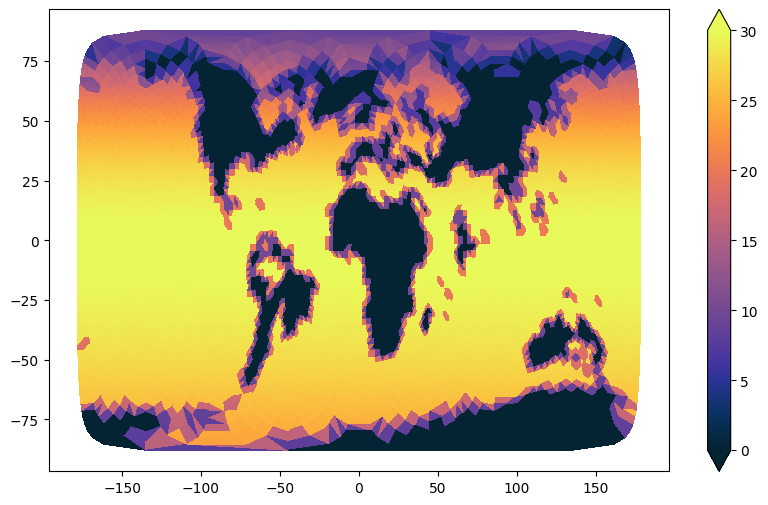

In [1358]:
# month = 0 # initialize iterater 
# thetaClim = np.array([thetaClim[month]*landmask for month in range(12)])
thetaClim = np.empty((2,32,192))
thetaClim[0] = thetaClim_regridded_bs * bathymask[0]
thetaClim[1] = thetaClim_regridded_bw * bathymask[0]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
thetaClim_plot = thetaClim[1]
# thetaClim_plot[np.isnan(landmask_default)] = np.nan
im = ax.tripcolor(XC.flatten(),YC.flatten(),thetaClim_plot.flatten(), cmap=cmocean.cm.thermal)
# カラーバーを追加
fig.colorbar(im, ax=ax,extend='both')
# プロットを表示
plt.show()
thetaClim[np.isnan(thetaClim)] = 0. #fill nan 0 for computation


In [1359]:
# # month = 0 # initialize iterater 
# # thetaClim = np.array([thetaClim[month]*landmask for month in range(12)])
# thetaClim = np.empty((12,32,192))
# thetaClim[:] = thetaClim_regridded * bathymask[0]
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)
# # データをプロット
# thetaClim_plot = thetaClim[-1]
# # thetaClim_plot[np.isnan(landmask_default)] = np.nan
# im = ax.tripcolor(XC.flatten(),YC.flatten(),thetaClim_plot.flatten(), cmap=cmocean.cm.thermal)
# # カラーバーを追加
# fig.colorbar(im, ax=ax,extend='both')
# # プロットを表示
# plt.show()
# thetaClim[np.isnan(thetaClim)] = 0. #fill nan 0 for computation


In [1360]:
mit.writebin(fileloc_to_write+filename_SST,thetaClim,dataprec='float64')

SSSは極座標のものを東西平均、南北対称にして用いる

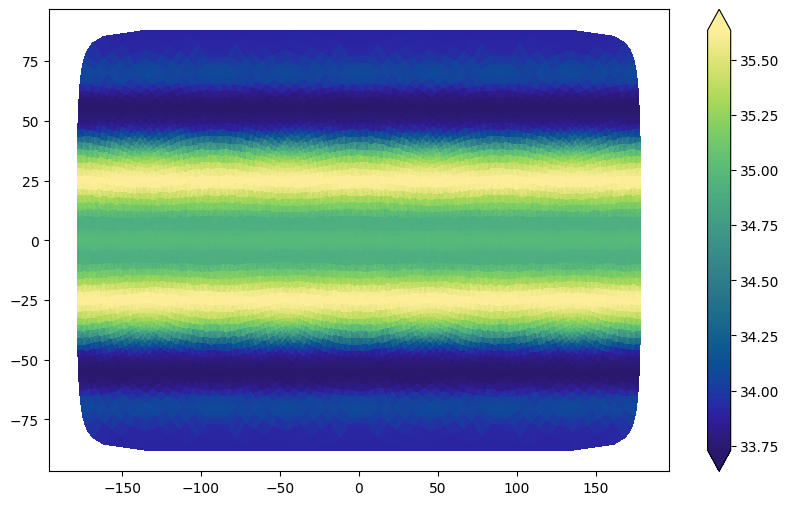

In [53]:
saltClim = mit.readbin(fileloc_go_input+'SSS_lev_polar_sym.bin',(12,32,192),'float64')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
# thetaClim_plot = thetaClim[7]
im = ax.tripcolor(XC.flatten(),YC.flatten(),saltClim[-1].flatten(), cmap=cmocean.cm.haline)
# カラーバーを追加
fig.colorbar(im, ax=ax,extend='both')
# プロットを表示
plt.show()

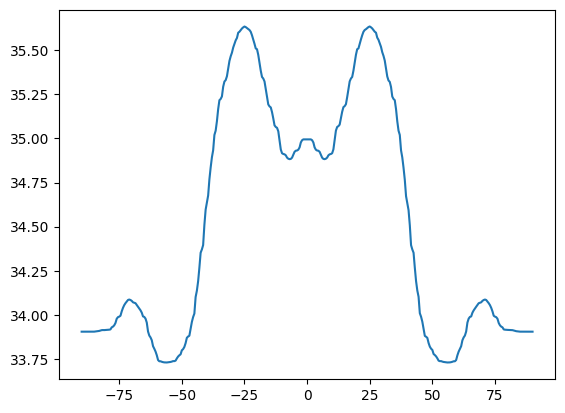

In [54]:
saltClim_regrid= regrid_data(XCYC,lonlat,top_indices_XCYC_to_lonlat,top_norms_XCYC_to_lonlat,saltClim[-1].astype('<f8'))
plt.plot(lat[:,60], saltClim_regrid[:,60] )


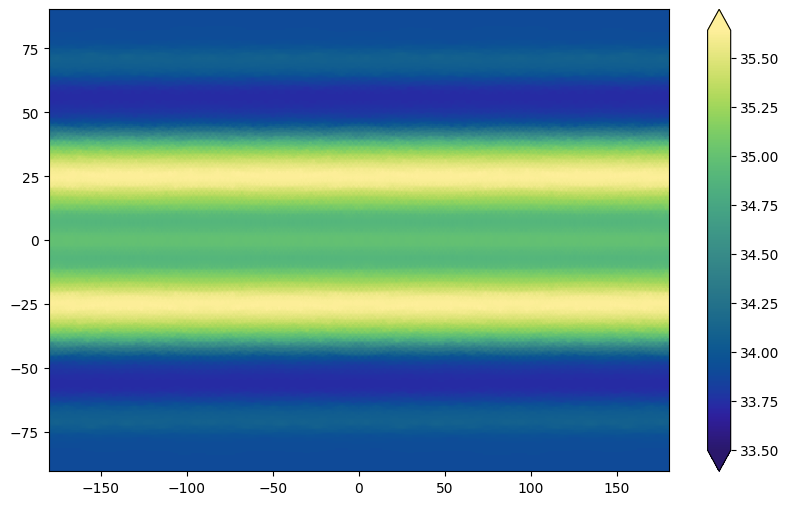

In [55]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
# thetaClim_plot = thetaClim[7]
im = ax.pcolormesh(lon,lat,saltClim_regrid, cmap=cmocean.cm.haline, vmin=33.5)
# カラーバーを追加
fig.colorbar(im, ax=ax,extend='both')
# プロットを表示
plt.show()

1/26~
北極海(北緯76.5度以北)を20‰まで低塩化

In [56]:

saltClim_regrid[np.argmin(np.abs(lat_ -76.5)):,:] = 20.0

北緯４８度以北76．5度以南の大西洋のSSSを0.98倍、太平洋のSSSを1.02倍
→1/31~  北緯４８度以北76．5度以南の大西洋のSSSを0.98倍、太平洋のSSSを1.02倍
2/2~北緯４８度以北76．5度以南の大西洋のSSSを0.95倍、太平洋のSSSを1.05倍
2/4~北緯41.5度以北76．5度以南の大西洋のSSSを0.97倍、太平洋のSSSを1.03倍

In [57]:
np.argmin(np.abs(lat_ -48))
np.argmin(np.abs(lat_ -76.5))

333

In [58]:
np.argmin(np.abs(lon_ -(-100)))
np.argmin(np.abs(lon_ -(25)))

410

In [59]:
saltClim_regrid[np.argmin(np.abs(lat_ -41.5)):np.argmin(np.abs(lat_ -76.5)),np.argmin(np.abs(lon_ -(-100))):np.argmin(np.abs(lon_ -(25)))] *= 0.97


In [60]:
saltClim_regrid[np.argmin(np.abs(lat_ -41.5)):np.argmin(np.abs(lat_ -76.5)),np.argmin(np.abs(lon_ -(150))):] *= 1.03

saltClim_regrid[np.argmin(np.abs(lat_ -41.5)):np.argmin(np.abs(lat_ -76.5)),:np.argmin(np.abs(lon_ -(-100)))] *= 1.03


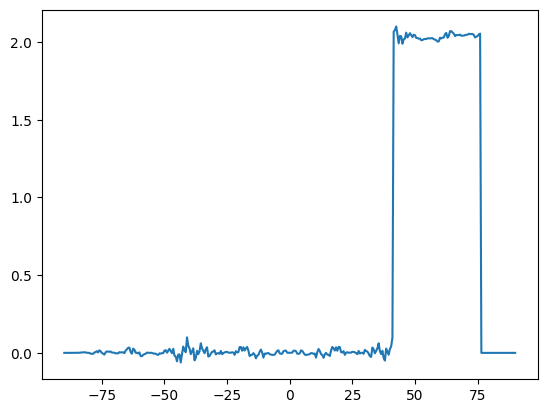

In [61]:
plt.plot(lat[:,60], saltClim_regrid[:,60]-saltClim_regrid[:,360] )


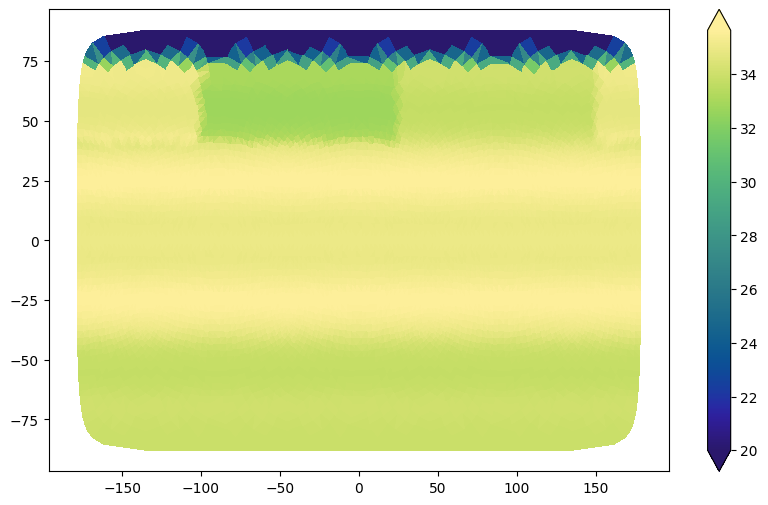

In [62]:
saltClim_reregrid = regrid_data(lonlat,XCYC,top_indices_lonlat_to_XCYC,top_norms_lonlat_to_XCYC,saltClim_regrid.astype('<f8'))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
# データをプロット
# thetaClim_plot = thetaClim[7]
im = ax.tripcolor(XC.flatten(),YC.flatten(),saltClim_reregrid.flatten(), cmap=cmocean.cm.haline)
# カラーバーを追加
fig.colorbar(im, ax=ax,extend='both')
# プロットを表示
plt.show()

In [87]:
month = 0 # initialize iterater 
# saltClim = np.array([saltClim[month]*bathymask[0] for month in range(12)])
# saltClim = np.array([saltClim_reregrid*bathymask[0] for month in range(12)])
saltClim = np.array([saltClim_reregrid*bathymask[0] for month in range(2)]) #半年ごと
# saltClim = np.array([saltClim_reregrid for month in range(2)]) #半年ごと




In [83]:
bathymask

array([[[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

/home/tsuribeh/.local/lib/python3.10/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


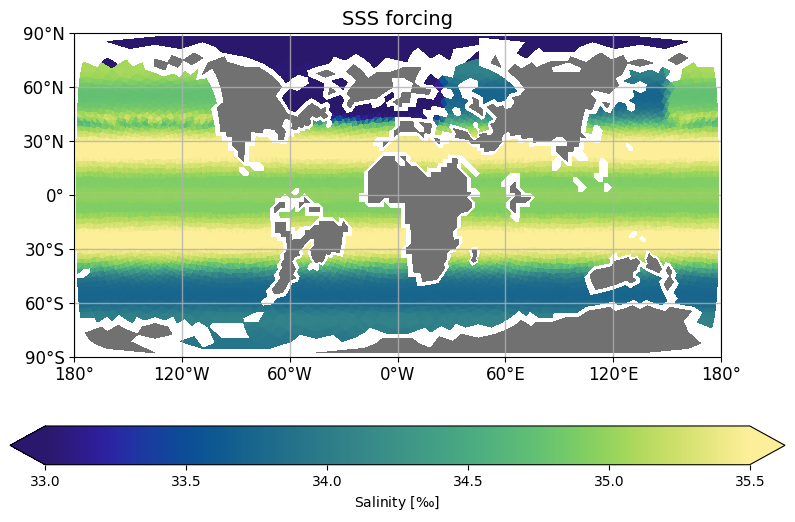

In [89]:
fig = plt.figure(figsize=(10, 6))
# bmap = ccrs.Orthographic()
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_facecolor('grey')
# データをプロット
saltClim[saltClim==0.] = np.nan
# norm=TwoSlopeNorm(vcenter=33)
# im = ax.tripcolor(XC.flatten(),YC.flatten(),saltClim[-1].flatten(), cmap=cmocean.cm.haline#, norm= norm
                #   )
im = ax.tripcolor(XC.flatten(),YC.flatten(),saltClim[-1].flatten(), cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), vmax= 35.5, vmin= 33)



# カラーバーを追加
cb = fig.colorbar(im, ax=ax, orientation="horizontal",extend='both')

cb.set_label("Salinity [$\perthousand$]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)
# タイトルと表示
# ax.set_title("Zonal velosity(Pm30Ma) at " + str(RC[depth_idx]) + "m", fontsize=14)
ax.set_title("SSS forcing", fontsize=14)

# ax.legend()

land_mask = np.where(bathymask[0]==0.,1., np.nan)
ax.tripcolor(XC.flatten(),YC.flatten(),land_mask.flatten(),cmap=cmocean.cm.gray, vmax= 2.,vmin=0.)

plt.show()
saltClim[np.isnan(saltClim)] = 0.


In [1373]:
#save faile
mit.writebin(fileloc_to_write+filename_SSS,saltClim,dataprec='float64')

In [1374]:
# #Don't work so well near Prime meridian and 180deg. meridian--> Because of pole problem?

# def calculate_top_l_indices_and_norms_balltree(XCYC1, XCYC2, l):
#     """
#     XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（BallTree を使用）。

#     Args:
#         XCYC1 (ndarray): 座標データ（形状: [m, n, 2], 緯度・経度はラジアン）
#         XCYC2 (ndarray): 対応する座標データ（形状: [p, q, 2], 緯度・経度はラジアン）
#         l (int): 最近傍点の数

#     Returns:
#         top_l_indices (ndarray): ノルムが小さい順に l 点のインデックス（形状: [p, q, l, 2]）
#         top_l_norms (ndarray): ノルムが小さい順に l 点の値（形状: [p, q, l]）
#     """
#     # earth_rad = 6370. #in kilometer. according to MITgcm.
#     # onedeg_in_eq  = earth_rad  * np.pi / 180.   

#     XCYC1= np.deg2rad(XCYC1)
#     XCYC2= np.deg2rad(XCYC2)

#     # XCYC1 を平坦化
#     m, n = XCYC1.shape[:2]
#     flattened_XCYC1 = XCYC1.reshape(-1, 2)

#     # BallTree を構築
#     tree = BallTree(flattened_XCYC1, metric='haversine')

#     # 結果を格納する配列を初期化
#     top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
#     top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

#     # 各点に対して最近傍探索
#     for i in range(XCYC2.shape[0]):
#         for j in range(XCYC2.shape[1]):
#             # BallTree で最近傍探索（距離とインデックスを取得）
#             distances, indices = tree.query([XCYC2[i, j, :]], k=l)  # 上位 l 点を取得
#             distances = np.deg2rad(distances)

#             # インデックスを 2D の形状に変換
#             unraveled_indices = np.unravel_index(indices.flatten(), (m, n))

#             # 結果を格納
#             for k in range(l):
#                 top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]
#                 top_l_norms[i, j, k] = distances.flatten()[k] 
#     return top_l_indices, top_l_norms


# #works well to some extent, but not precise near poles 
# def calculate_top_l_indices_and_norms_kdtree(XCYC1, XCYC2,l):
#     """
#     XCYC2 の各点に対して、XCYC1 からノルムが小さい順にl点のインデックスとノルムを計算（KD-Tree を使用）。

#     Args:
#         XCYC1 (ndarray): 座標データ (形状: [m, n, 2])
#         XCYC2 (ndarray): 極座標データ (形状: [p, q, 2])
#         l (int): 使う点の数

#     Returns:
#         top_l_indices (ndarray): ノルムが小さい順に4点のインデックス (形状: [p, q, l, 2])
#         top_l_norms (ndarray): ノルムが小さい順に4点の値 (形状: [p, q, l])
#     """
#     # XCYC1 の形状を取得
#     m, n = XCYC1.shape[:2]
#     flattened_XCYC1 = XCYC1.reshape(-1, 2)  # XCYC1 を平坦化


#     # KD-Tree を構築
#     tree = kdtree_scipy(flattened_XCYC1)

#     # 結果を格納する配列を初期化
#     top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
#     top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

#     # 各点に対して最近傍探索
#     for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
#         for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
#             # KD-Tree で最近傍探索（距離とインデックスを取得）
#             distances, indices = tree.query(XCYC2[i, j, :], k=l)  # 上位4点を取得

#             # インデックスを 2D の形状に変換
#             unraveled_indices = np.unravel_index(indices, (m, n))

#             # 結果を格納
#             for k in range(l):
#                 top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]
#                 top_l_norms[i, j, k] = distances[k]

#     return top_l_indices, top_l_norms

In [1375]:
# cmap_names = cmocean.cm.cmapnames
# custom_cmaps = {}
# for cmap_name in cmap_names:
#     cmap = cmocean.cm.__dict__[cmap_name].copy()  # カラーマップをコピー
#     cmap.set_bad(color='green')  # NaN 値を緑色に設定
#     custom_cmaps[cmap_name] = cmap  # カスタムカラーマップを保存

In [1376]:
# # # パラメータの範囲を設定
# # l_values = range(1,33)
# # p_values = range(1,17)
# # # RMSE を格納する配列
# # rmse_values = np.zeros((len(l_values), len(p_values)))

# # # パラメータごとの計算
# # for l_value in l_values: #lを32まで
# #     # 最近傍点を計算
# #     top_8_indices_XCYC_to_lonlat, top_8_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=l_value)
# #     top_8_indices_lonlat_to_XCYC, top_8_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=l_value)

# #     for p_value in p_values:  # p を 1 から 16 まで
# #         # 再グリッド
# #         bathy_regridded = regrid_data(lonlat, XCYC, top_8_indices_lonlat_to_XCYC, top_8_norms_lonlat_to_XCYC, bathy_raw, p=float(p_value))
# #         bathy_re_regridded = regrid_data(XCYC, lonlat, top_8_indices_XCYC_to_lonlat, top_8_norms_XCYC_to_lonlat, bathy_regridded, p=float(p_value))

# #         # 差分を計算
# #         difference = bathy_re_regridded - bathy_raw
# #         rmse = np.linalg.norm(np.array(difference).flatten()) / len(np.array(difference).flatten())**0.5

# #         # RMSE を格納
# #         rmse_values[l_value-1, p_value-1] = rmse

# # RMSE の最小値と対応する l, p を計算
# min_rmse = rmse_values.min()
# min_indices = np.unravel_index(np.argmin(rmse_values), rmse_values.shape)
# best_l = l_values[min_indices[0]]
# best_p = p_values[min_indices[1]]

# # 結果を出力
# print(f"最小 RMSE: {min_rmse}")
# print(f"最適な l: {best_l}")
# print(f"最適な p: {best_p}")

# # ヒートマップをプロット
# plt.figure(figsize=(10, 8))
# plt.imshow(rmse_values, aspect='auto', origin='lower', extent=[min(p_values), max(p_values), min(l_values), max(l_values)])
# plt.colorbar(label='RMSE')
# plt.xlabel('p (重みパラメータ)')
# plt.ylabel('l (最近傍点の数)')
# plt.title('RMSE ヒートマップ')
# plt.show()

